# 用KNN算法完成分类任务

In [4]:
import matplotlib.pyplot as plt
import numpy as np

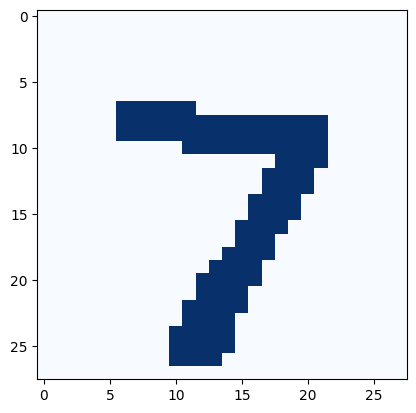

In [4]:
# 读取数据集
m_x = np.loadtxt('data/mnist_x')
m_y = np.loadtxt('data/mnist_y')

# 数据可视化
data = np.reshape(np.array(m_x[0],dtype=int),[28,28])
plt.figure()
plt.imshow(data,cmap='Blues')

In [5]:
# 将数据集分为训练集和测试集
ratio = 0.8
split = int(len(m_x) * ratio)

# 打乱数据
np.random.seed(2023)
idx = np.random.permutation(np.arange(len(m_x)))
m_x = m_x[idx]
m_y = m_y[idx]
x_train,x_test = m_x[:split],m_x[split:]
y_train,y_test = m_y[:split],m_y[split:]

# 定义样本之间的距离
# 欧式距离
def distance(a,b):
    return np.sqrt(np.sum(np.square(a - b)))

In [6]:
# KNN算法类
class KNN:
    def __init__(self,k,label_num):
        # 设置k，标签数量
        self.k = k
        self.label_num = label_num

    def fit(self,x_train,y_train):
        # 在类中保存训练数据
        self.x_train = x_train
        self.y_train = y_train

    def get_knn_indices(self,x):
        # 获取距离目标最近的K个样本点的下标
        # 计算已知样本到目标样本的距离
        dis = list(map(lambda a:distance(a,x),self.x_train))
        # 按距离从小到大排序，获得对应下标
        knn_indices = np.argsort(dis)
        # 取最近的k个下标
        knn_indices = knn_indices[:self.k]
        return knn_indices

    def get_label(self,x):
        # KNN方法的具体实现，观察k个近邻并获取数量最多的类别
        knn_indices = self.get_knn_indices(x)
        # 类别计数
        label_statistic = np.zeros(shape=[self.label_num])
        for index in knn_indices:
            label = int(self.y_train[index])
            label_statistic[label] += 1
        # 返回数量最多的类型
        return np.argmax(label_statistic)

    def predict(self,x_test):
        # 预测样本x_test的类别
        predicted_test_labels = np.zeros(shape=[len(x_test)],dtype=int)
        for i,x in enumerate(x_test):
            predicted_test_labels[i] = self.get_label(x)
        return predicted_test_labels


In [7]:
# 在测试集上观察算法的效果
for k in range(1,10):
    knn = KNN(k,label_num=10)
    knn.fit(x_train,y_train)
    predicted_labels = knn.predict(x_test)
    accuracy = np.mean(predicted_labels == y_test)
    print(f'K的取值为{k},预测准确率为{accuracy * 100:.1f}%')

K的取值为1,预测准确率为88.5%
K的取值为2,预测准确率为86.5%
K的取值为3,预测准确率为87.5%
K的取值为4,预测准确率为86.0%
K的取值为5,预测准确率为87.0%
K的取值为6,预测准确率为86.5%
K的取值为7,预测准确率为86.5%
K的取值为8,预测准确率为86.5%
K的取值为9,预测准确率为86.0%


# 使用scikit-learn实现KNN算法

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap

# 读入高斯数据集
data = np.loadtxt('data/gauss.csv',delimiter=',')
x_train = data[:,:2]
y_train = data[:,2]
print('数据集大小：',len(x_train))

数据集大小： 200


In [18]:
x_train[y_train == 0, 0]

array([ 2.2212,  0.3717,  2.2861,  1.7738,  1.5953,  3.1068,  0.9145,
        2.2294, -0.7081,  0.9669,  0.4665,  0.0373,  0.2293,  0.5631,
        0.595 , -0.5676,  1.1846,  2.1784,  1.1091,  0.7573,  0.3364,
        1.2327,  2.1532,  1.376 , -0.2677,  1.5625, -0.179 ,  1.0549,
        1.1089,  0.3687,  0.873 ,  0.7622,  0.9254,  1.7375,  1.2406,
        2.5183,  2.3996,  2.1049,  1.0121,  2.0828,  0.6523,  0.6546,
        1.5356,  0.7269,  1.6782,  1.028 ,  2.2825,  1.8667,  0.9754,
        1.8984,  1.7634,  0.6886,  2.4475,  1.4216,  0.6403,  0.5053,
        0.7716,  1.1517,  1.1404,  1.1313,  0.1098,  0.9439,  1.0211,
        1.3676,  1.4407,  1.3931, -0.108 ,  0.3847,  1.5712,  1.0168,
       -0.5505, -0.166 ,  0.8845, -0.828 ,  1.2767,  2.3172,  1.1407,
       -0.3236,  0.343 ,  1.2755,  1.0716,  0.5495,  0.4633,  0.6766,
        1.5008,  0.5598,  0.8294,  1.3973,  1.3809,  0.2711,  0.7326,
        0.3114,  1.3355,  1.9728,  0.2146,  0.8375, -0.0332,  0.2804,
        1.1237,  2.1

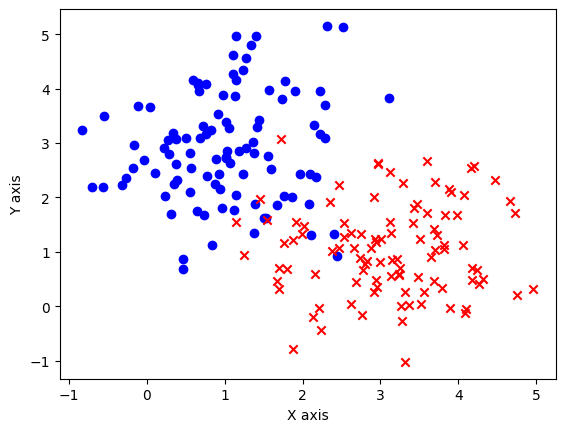

In [20]:
# 数据可视化
plt.figure()
plt.scatter(x_train[y_train == 0, 0], x_train[y_train == 0, 1], c='blue', marker='o')
plt.scatter(x_train[y_train == 1, 0], x_train[y_train == 1, 1], c='red', marker='x')
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.show()

In [26]:
# 设置步长
step = 0.1
# 设置网格边界
x_min, x_max = np.min(x_train[:, 0]) - 1, np.max(x_train[:, 0]) + 1 
y_min, y_max = np.min(x_train[:, 1]) - 1, np.max(x_train[:, 1]) + 1
# 构造网格
xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))
grid_data = np.concatenate([xx.reshape(-1, 1), yy.reshape(-1, 1)], axis=1)

In [23]:
xx,yy

(array([[-1.828, -1.808, -1.788, ...,  5.912,  5.932,  5.952],
        [-1.828, -1.808, -1.788, ...,  5.912,  5.932,  5.952],
        [-1.828, -1.808, -1.788, ...,  5.912,  5.932,  5.952],
        ...,
        [-1.828, -1.808, -1.788, ...,  5.912,  5.932,  5.952],
        [-1.828, -1.808, -1.788, ...,  5.912,  5.932,  5.952],
        [-1.828, -1.808, -1.788, ...,  5.912,  5.932,  5.952]]),
 array([[-2.0207, -2.0207, -2.0207, ..., -2.0207, -2.0207, -2.0207],
        [-2.0007, -2.0007, -2.0007, ..., -2.0007, -2.0007, -2.0007],
        [-1.9807, -1.9807, -1.9807, ..., -1.9807, -1.9807, -1.9807],
        ...,
        [ 6.0993,  6.0993,  6.0993, ...,  6.0993,  6.0993,  6.0993],
        [ 6.1193,  6.1193,  6.1193, ...,  6.1193,  6.1193,  6.1193],
        [ 6.1393,  6.1393,  6.1393, ...,  6.1393,  6.1393,  6.1393]]))

In [24]:
grid_data

array([[-1.828 , -2.0207],
       [-1.808 , -2.0207],
       [-1.788 , -2.0207],
       ...,
       [ 5.912 ,  6.1393],
       [ 5.932 ,  6.1393],
       [ 5.952 ,  6.1393]])

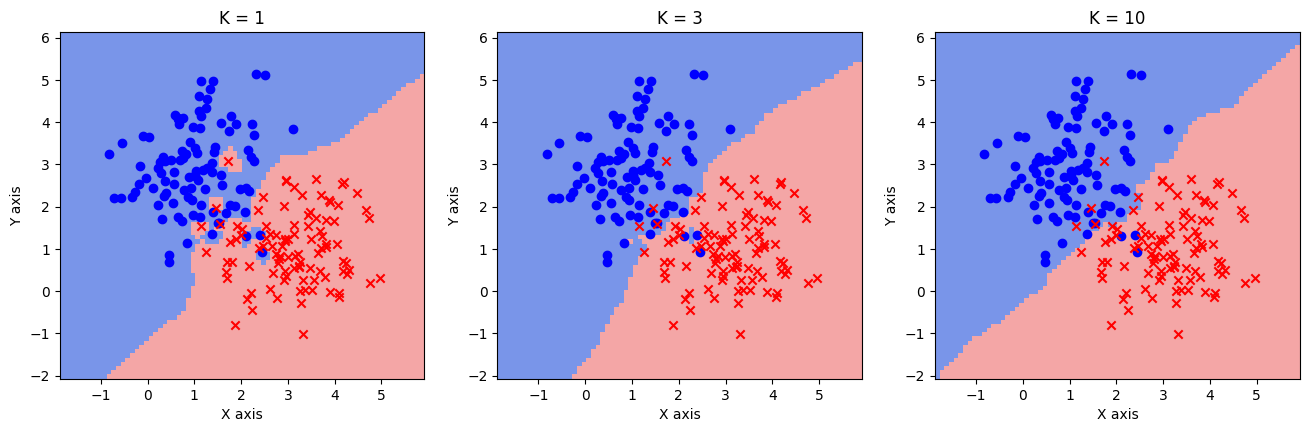

In [34]:
fig = plt.figure(figsize=(16,4.5))
# K值，读者可以自行调整，观察分类结果的变化
ks = [1, 3, 10] 
cmap_light = ListedColormap(['royalblue', 'lightcoral'])

for i, k in enumerate(ks):
    # 定义KNN分类器
    knn = KNeighborsClassifier(n_neighbors=k) 
    knn.fit(x_train, y_train)
    z = knn.predict(grid_data)

    # 画出分类结果
    ax = fig.add_subplot(1, 3, i + 1)
    ax.pcolormesh(xx, yy, z.reshape(xx.shape), cmap=cmap_light, alpha=0.7)
    ax.scatter(x_train[y_train == 0, 0], x_train[y_train == 0, 1], c='blue', marker='o')
    ax.scatter(x_train[y_train == 1, 0], x_train[y_train == 1, 1], c='red', marker='x')

    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_title(f'K = {k}')
plt.show()

# Others
- map()函数的用法https://blog.csdn.net/qq_41554005/article/details/119931689
- enumerate()函数的用法https://blog.csdn.net/churximi/article/details/51648388
- np.readtxt()函数的用法https://blog.csdn.net/cyh153296/article/details/83502076
- plt.scatter()函数的用法https://blog.csdn.net/gongdiwudu/article/details/129947219
- np.meshgrid()函数的用法https://blog.csdn.net/xbinworld/article/details/107451926
- np.concatenate()函数的用法https://blog.csdn.net/kekeshu_k/article/details/109110916